`cd project/seniorthesis/notebooks`

`conda list PyCO2SYS`

`pip install PyCO2SYS`

`pip install git+https://github.com/jbusecke/cmip6_preprocessing.git`

`mv *.png ../figures`

In [1]:
import xarray as xr
import xesmf as xe
from cmip6_preprocessing.preprocessing import combined_preprocessing
import PyCO2SYS as pyco2 # i have to install this package through terminal for it to work
import intake
import matplotlib.pyplot as plt
import numpy as np
import warnings
import gsw
from cmip6_preprocessing.postprocessing import combine_datasets
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cmocean
import matplotlib.path as mpath
from cmip6_preprocessing.postprocessing import combine_datasets
from cmip6_preprocessing.postprocessing import merge_variables
from dask.diagnostics import ProgressBar
from xgcm import Grid
from xhistogram.xarray import histogram
import pandas as pd
import scipy

In [2]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

variables = ['areacello']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Ofx'], 
             variable_id=variables,
             grid_label=['gr'],
              source_id=['GFDL-ESM4']
            )


cat = col.search(**query)

# print(cat.df['source_id'].unique())
dd_gr = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)

# dd_gr = merge_variables(dd_gr)

# temp={}
# for name,item in dd_gr.items():
#     #print(name)
#     #print(item.data_vars)
#     present = item.data_vars
#     if all(i in present for i in variables):
#         #print(name)
#         temp[name]=item
# dd_gr = temp
# list(dd_new_gr.keys())

dd_gr = combine_datasets(
    dd_gr,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_gr.keys())
# dd_new_new_gr


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


['GFDL-ESM4.gr.historical.Ofx']

# `A` is area averaged over entire x

In [3]:
A = dd_gr['GFDL-ESM4.gr.historical.Ofx'].mean([ 'x'],keep_attrs=True).areacello
A

<xarray.DataArray 'areacello' (y: 180)>
dask.array<mean_agg-aggregate, shape=(180,), dtype=float32, chunksize=(180,), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Attributes:
    cell_methods:   area: sum
    comment:        Model data on the 1x1 grid includes values in all cells f...
    interp_method:  conserve_order1
    long_name:      Grid-Cell Area
    original_name:  areacello
    standard_name:  cell_area
    units:          m²

# `A_pac` is area averaged over Pacific Basin

In [4]:
A_pac = dd_gr['GFDL-ESM4.gr.historical.Ofx'].isel(x=slice(180,200)).mean('x', keep_attrs=True).areacello
A_pac

<xarray.DataArray 'areacello' (y: 180)>
dask.array<mean_agg-aggregate, shape=(180,), dtype=float32, chunksize=(180,), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Attributes:
    cell_methods:   area: sum
    comment:        Model data on the 1x1 grid includes values in all cells f...
    interp_method:  conserve_order1
    long_name:      Grid-Cell Area
    original_name:  areacello
    standard_name:  cell_area
    units:          m²

In [5]:
newcoords = {'x':dd_gr['GFDL-ESM4.gr.historical.Ofx'].areacello['x'], 'y':dd_gr['GFDL-ESM4.gr.historical.Ofx'].areacello['y']}
newcoords
# newcoords2 = {'y':dd_gr['GFDL-ESM4.gr.historical.Ofx'].mean(['x'],keep_attrs=True).areacello['y']}
# newcoords2

{'x': <xarray.DataArray 'x' (x: 360)>
 array([  0.5,   1.5,   2.5, ..., 357.5, 358.5, 359.5])
 Coordinates:
   * x        (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
 Attributes:
     axis:           X
     bounds:         lon_bnds
     cell_methods:   time: point
     long_name:      longitude
     standard_name:  longitude
     units:          degrees_E,
 'y': <xarray.DataArray 'y' (y: 180)>
 array([-89.5, -88.5, -87.5, -86.5, -85.5, -84.5, -83.5, -82.5, -81.5, -80.5,
        -79.5, -78.5, -77.5, -76.5, -75.5, -74.5, -73.5, -72.5, -71.5, -70.5,
        -69.5, -68.5, -67.5, -66.5, -65.5, -64.5, -63.5, -62.5, -61.5, -60.5,
        -59.5, -58.5, -57.5, -56.5, -55.5, -54.5, -53.5, -52.5, -51.5, -50.5,
        -49.5, -48.5, -47.5, -46.5, -45.5, -44.5, -43.5, -42.5, -41.5, -40.5,
        -39.5, -38.5, -37.5, -36.5, -35.5, -34.5, -33.5, -32.5, -31.5, -30.5,
        -29.5, -28.5, -27.5, -26.5, -25.5, -24.5, -23.5, -22.5, -21.5, -20.5,
        -19.5, -18.5, -17.5, -16.5,

In [6]:
dd = {}
dd['UKESM1-0-LL.gn.historical.Omon'] = xr.open_mfdataset('UKESM1_*_20yr.nc')
dd['CanESM5-CanOE.gn.historical.Omon']= xr.open_mfdataset('CanESM5CanOE*_20yr.nc')
dd['CNRM-ESM2-1.gn.historical.Omon']= xr.open_mfdataset('CNRM*_20yr.nc')
dd['CanESM5.gn.historical.Omon']= xr.open_mfdataset('CanESM5_*_20yr.nc')
dd['IPSL-CM6A-LR.gn.historical.Omon']= xr.open_mfdataset('IPSL*_20yr.nc')
dd['CESM2-WACCM.gr.historical.Omon']= xr.open_mfdataset('CESM2-WACCM_*_20yr.nc')
dd['CESM2.gr.historical.Omon']= xr.open_mfdataset('CESM2_*_20yr.nc')
dd['CESM2-WACCM-FV2.gr.historical.Omon']= xr.open_mfdataset('CESM2-WACCM-FV2_*_20yr.nc')
dd['GFDL-ESM4.gr.historical.Omon']= xr.open_mfdataset('GFDL-ESM4_*_20yr.nc')
dd['CESM2-FV2.gr.historical.Omon']= xr.open_mfdataset('CESM2-FV2_*_20yr.nc')
dd['GFDL-CM4.gr.historical.Omon']= xr.open_mfdataset('GFDL-CM4_*_20yr.nc')
dd['MRI-ESM2-0.gr.historical.Omon']= xr.open_mfdataset('MRI-ESM2-0_*_20yr.nc')
# A = xr.open_mfdataset('AREA.nc')

In [7]:
for name, ds in dd.items():
    ds['p'] = gsw.p_from_z(-1*ds['lev'], ds['y'], geo_strf_dyn_height=0, sea_surface_geopotential=0)*xr.ones_like(ds['talk']) # expand along time dimension
    ds['insitutemp'] = gsw.t_from_CT(ds['so'], ds['thetao'], ds['p'])
    ds['sigma2'] = gsw.sigma2(ds['so'],ds['thetao'])
    ds['sigma0'] = gsw.sigma0(ds['so'],ds['thetao'])

In [8]:
for name, ds in dd.items():
    dd[name] = ds.assign_coords(**newcoords)

In [9]:
dd_x = {}
dd_x['UKESM1-0-LL.gn.historical.Omon'] = xr.open_mfdataset('UKESM1_*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)
dd_x['CanESM5-CanOE.gn.historical.Omon']= xr.open_mfdataset('CanESM5CanOE*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)
dd_x['CNRM-ESM2-1.gn.historical.Omon']= xr.open_mfdataset('CNRM*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)
dd_x['CanESM5.gn.historical.Omon']= xr.open_mfdataset('CanESM5_*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)
dd_x['IPSL-CM6A-LR.gn.historical.Omon']= xr.open_mfdataset('IPSL*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)
dd_x['CESM2-WACCM.gr.historical.Omon']= xr.open_mfdataset('CESM2-WACCM_*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)
dd_x['CESM2.gr.historical.Omon']= xr.open_mfdataset('CESM2_*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)
dd_x['CESM2-WACCM-FV2.gr.historical.Omon']= xr.open_mfdataset('CESM2-WACCM-FV2_*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)
dd_x['GFDL-ESM4.gr.historical.Omon']= xr.open_mfdataset('GFDL-ESM4_*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)
dd_x['CESM2-FV2.gr.historical.Omon']= xr.open_mfdataset('CESM2-FV2_*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)
dd_x['GFDL-CM4.gr.historical.Omon']= xr.open_mfdataset('GFDL-CM4_*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)
dd_x['MRI-ESM2-0.gr.historical.Omon']= xr.open_mfdataset('MRI-ESM2-0_*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)

for name, ds in dd_x.items():
    da = dd[name]
    ds['p'] = gsw.p_from_z(-1*ds['lev'], ds['y'], geo_strf_dyn_height=0, sea_surface_geopotential=0)*xr.ones_like(ds['talk']) # expand along time dimension
    ds['insitutemp'] = gsw.t_from_CT(da['so'], da['thetao'], ds['p']).isel(x=slice(180,200)).mean('x', keep_attrs=True)
    ds['sigma2'] = gsw.sigma2(da['so'],da['thetao']).isel(x=slice(180,200)).mean('x', keep_attrs=True)
    ds['sigma0'] = gsw.sigma0(da['so'],da['thetao']).isel(x=slice(180,200)).mean('x', keep_attrs=True)
    


In [10]:
newercoords = {'y':dd_gr['GFDL-ESM4.gr.historical.Ofx'].areacello['y']}

for name, ds in dd_x.items():
    dd_x[name] = ds.assign_coords(**newercoords)


In [11]:
PCO2_x = {}
for name, ds in dd_x.items():
    conversion =  1e6/1035
    results = pyco2.sys(par1=ds['talk']*conversion,par2=ds['dissic']*conversion,par1_type=1,par2_type=2,
                        pressure_out=0, temperature_out = ds['thetao'], pressure = ds['p'], 
                        temperature = ds['insitutemp'])
    PCO2_x[name] = results['pCO2_out']

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.

# Trying to get PCO2 in density space
## `PCO2_sigma` is PCO2 in density space for Pacific Basin

In [12]:
from xgcm import Grid

grid = Grid(ds, coords={'Z': {'center':'lev'}}, periodic=False)
target = np.linspace(35, 37, 30)

# fig, axarr = plt.subplots(nrows = 6, ncols = 2, figsize=[20,20])
# fig.tight_layout(pad = 3.5)
# plt.rc('font', size = 14)
# plt.rc('axes', titlesize= 14)    
# plt.rc('axes', labelsize= 14)
# plt.rc('figure', titlesize=16)

# ax_idx = 0

PCO2_sigma = {}

for name, ds in dd_x.items():

#     ax = axarr.flat[ax_idx]
    
    DIC = grid.transform(ds['dissic'], 'Z', target, target_data=ds['sigma2'], method = 'linear').transpose('sigma2','y')
    TALK = grid.transform(ds['talk'], 'Z', target, target_data=ds['sigma2'], method = 'linear').transpose('sigma2','y')
    THETAO = grid.transform(ds['thetao'], 'Z', target, target_data=ds['sigma2'], method = 'linear').transpose('sigma2','y')
    P = grid.transform(ds['p'], 'Z', target, target_data=ds['sigma2'], method = 'linear').transpose('sigma2','y')
    TEMP = grid.transform(ds['insitutemp'], 'Z', target, target_data=ds['sigma2'], method = 'linear').transpose('sigma2','y')
    conversion =  1e6/1035
    results = pyco2.sys(par1=TALK*conversion,par2=DIC*conversion,par1_type=1,par2_type=2,
                    pressure_out=0, temperature_out = THETAO, pressure = P, 
                    temperature = TEMP)

    PCO2_sigma[name] = DIC.copy(data=results['pCO2_out'])
#     ax.set_xlim([-80,-30])
#     im = ax.pcolormesh(ppco2['y'],ppco2['sigma2'], ppco2, vmin = 300, vmax = 600)
#     cbar = plt.colorbar(im,ax=ax)
#     cbar.set_label('Partial Pressure of CO2 (\u03BCatm)')
#     ax.invert_yaxis()
#     ax.set_title(name)
#     ax.set_xlabel('Latitude')
#     ax.set_ylabel('Potential Density - 1000 kg/m\u00b3')
#     ax_idx += 1

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: invalid value encountered

In [22]:
ds.sigma2

<xarray.DataArray 'sigma2' (lev: 61, y: 180)>
dask.array<where, shape=(61, 180), dtype=float64, chunksize=(61, 180), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lev      (lev) float64 1.0 3.5 6.5 10.0 ... 5.5e+03 6.15e+03 6.525e+03
Attributes:
    cell_measures:  area: areacello volume: volcello
    cell_methods:   area: mean where sea time: mean
    comment:        Sea water salinity is the salt content of sea water, ofte...
    history:        2020-02-12T04:39:28Z altered by CMOR: replaced missing va...
    long_name:      Sea Water Salinity
    standard_name:  sea_water_salinity

### PCO2 on 35.7 isopycnal zonally averaged

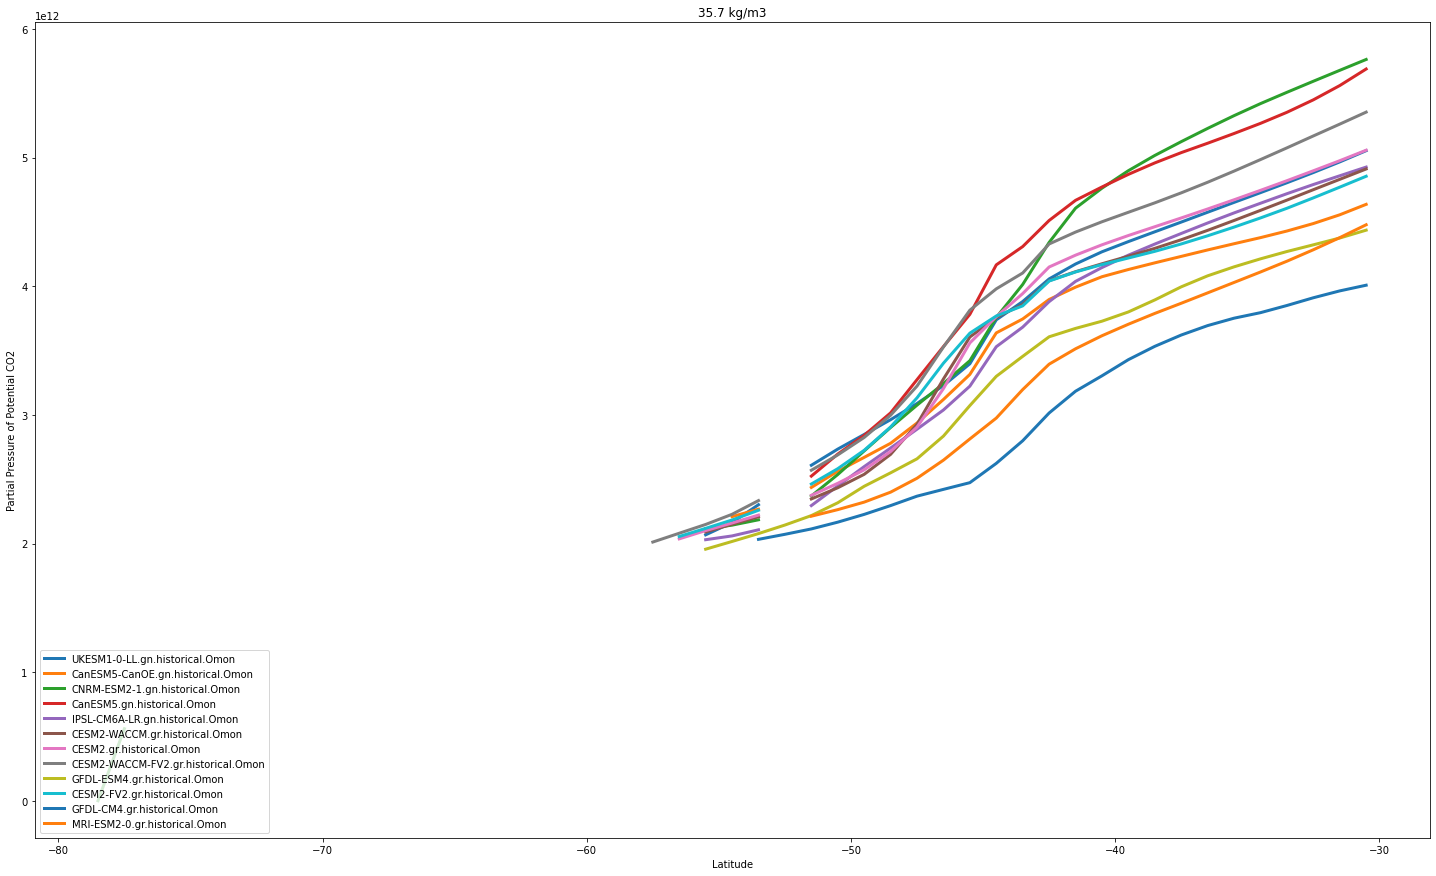

In [45]:
for name, ds in PCO2_sigma.items():
    plt.plot(ds.y[10:60], A_pac[10:60]*ds.sel(sigma2 = 35.7, method = 'nearest')[10:60], label = name, lw = 3)
    plt.xlabel('Latitude')
    plt.ylabel('Partial Pressure of Potential CO2')

plt.legend(
#     bbox_to_anchor=(1.05, 1), 
    loc='lower left'
#     , borderaxespad=0.
)
plt.title('35.7 kg/m3')
plt.rcParams["figure.figsize"] = (25,15)

### PCO2 on 36.029412 isopycnal zonally averaged

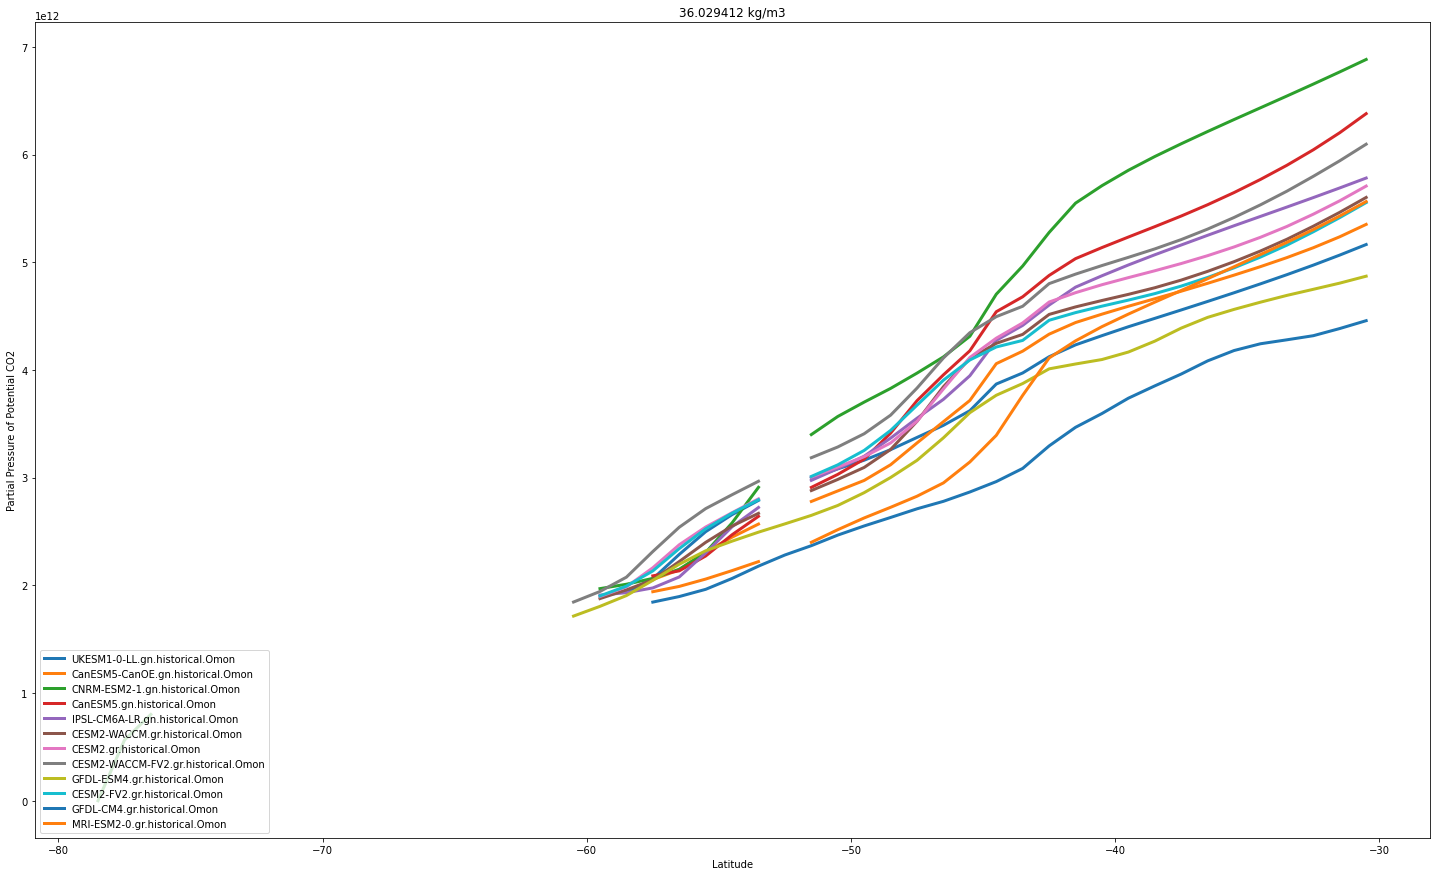

In [44]:
for name, ds in PCO2_sigma.items():
    plt.plot(ds.y[10:60], A_pac[10:60]*ds.sel(sigma2 = 36.029412, method = 'nearest')[10:60], label = name, lw = 3)
    plt.xlabel('Latitude')
    plt.ylabel('Partial Pressure of Potential CO2')

plt.legend(
#     bbox_to_anchor=(1.05, 1), 
    loc='lower left'
#     , borderaxespad=0.
)
plt.title('36.029412 kg/m3')
plt.rcParams["figure.figsize"] = (25,15)

# Zonally averaged surface upward flux of CO2

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.

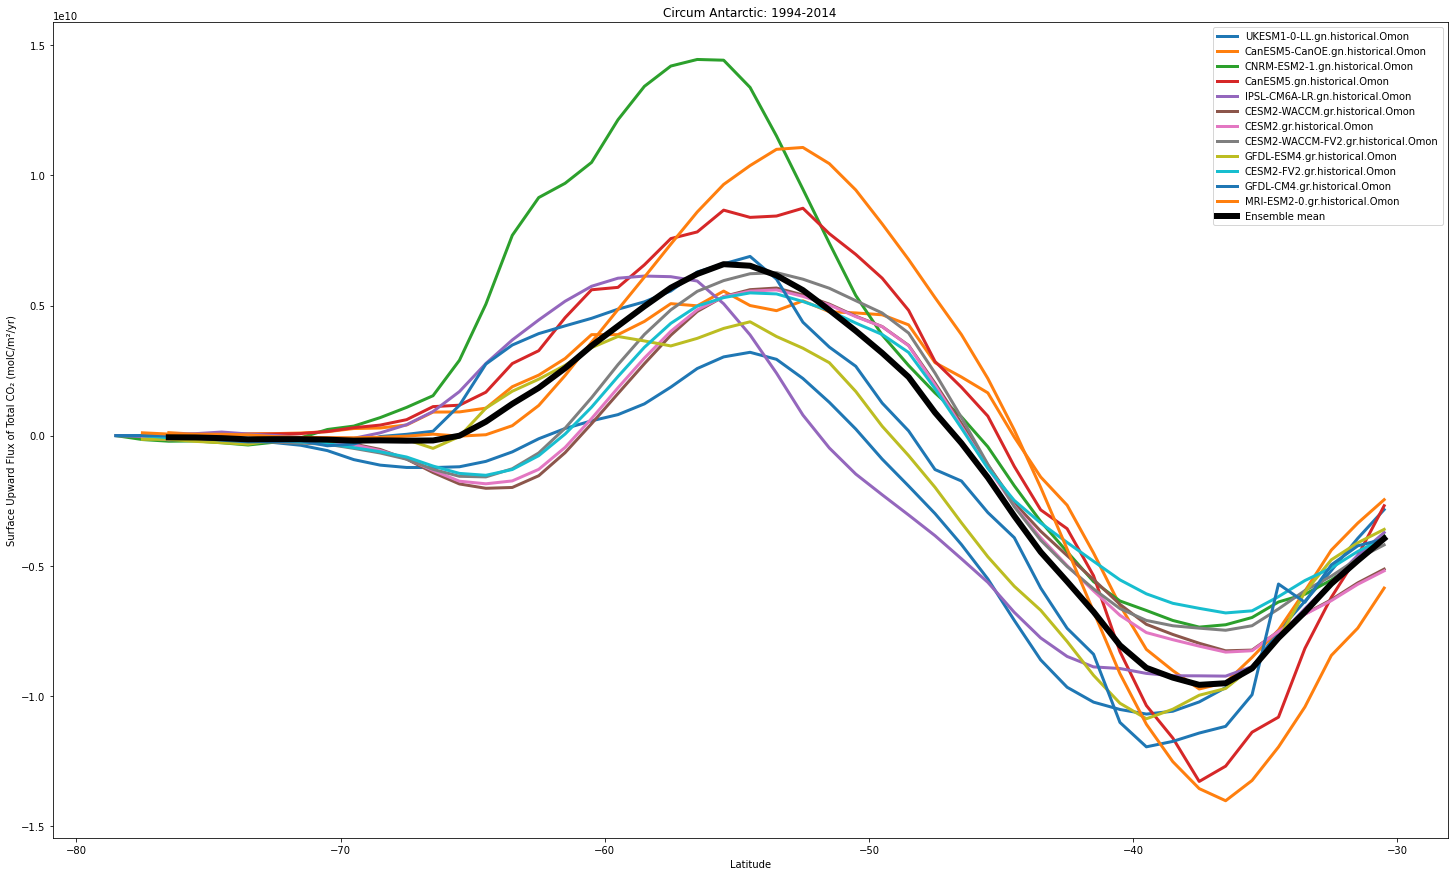

In [28]:
# d = dd['GFDL-CM4.gr.historical.Omon'].fgco2.mean(['x'],keep_attrs=True)
# d*A
temp = {}

conversion = 3.1536e7 * 83.3
for name, ds in dd.items():
    d = -1*ds.fgco2.mean(['x'],keep_attrs=True)*conversion
    ar = d*A
    temp[name]=ar
    

for name, ds in temp.items():
    plt.plot(ds.y[10:60], ds[10:60], label = name, lw = 3)
    plt.xlabel('Latitude')
    plt.ylabel('Surface Upward Flux of Total CO\u2082 (molC/m\u00b2/yr)')
    
mn = np.mean(list(temp.values()), axis=0)
plt.plot(ds.y[10:60], mn[10:60], lw = 6, label = 'Ensemble mean', color = 'black')
plt.xlabel('Latitude')
plt.ylabel('Surface Upward Flux of Total CO\u2082 (molC/m\u00b2/yr)')
# zr = xr.zeros_like(dd['CESM2-FV2.gr.historical.Omon'].fgco2)
# zr.isel(x = 0)[10:60].plot(linestyle = 'dashed', color = 'black')
# plt.xlabel('Latitude')
# plt.ylabel('Surface Upward Flux of Total CO\u2082 * Area (molC/yr)')

plt.legend(
#     bbox_to_anchor=(1.05, 1), 
    loc='upper right'
#     , borderaxespad=0.
)
plt.title('Circum Antarctic: 1994-2014')
plt.rcParams["figure.figsize"] = (25,15)

# Histogram of Area weighted `fgco2` by density `sigma2`

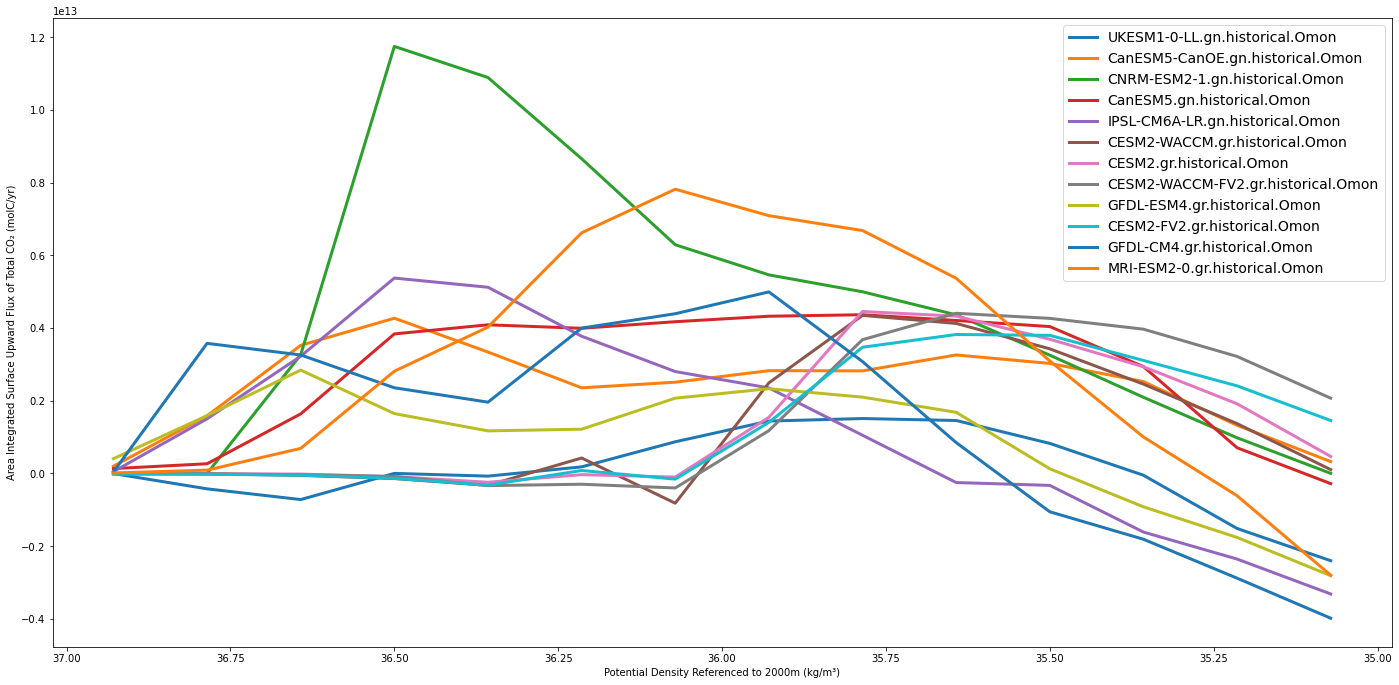

In [12]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=[20,10])
fig.tight_layout(pad = 3.5)
plt.rc('font', size = 14)
plt.rc('axes', titlesize= 14)    
plt.rc('axes', labelsize= 12)
plt.rc('figure', titlesize=16)

target = np.linspace(35, 37, 15)
binz = np.linspace(35, 37, 15)

conversion = 3.1536e7 * 83.3
ax_idx = 0
# for name, ds in dd.items():
for name, ds in dd.items():
#     ax = axarr.flat[ax_idx]
#     if name != 'GFDL-ESM4.gr.historical.Omon':
#         if name != 'GFDL-CM4.gr.historical.Omon':
    h2 = histogram(ds['sigma2'].isel(lev = 0)[10:60], bins = [binz], weights = -1*ds.fgco2[10:60]*A[10:60]*conversion) 
    h2.plot(label = name, lw = 3)
ax.invert_xaxis()
#     ax.set_title(name)
#     ax_idx += 1
ax.set_xlabel('Potential Density Referenced to 2000m (kg/m\u00b3)')
ax.set_ylabel('Area Integrated Surface Upward Flux of Total CO\u2082 (molC/yr)')
plt.legend(
#     bbox_to_anchor=(1.05, 1), 
    loc='upper right'
#     , borderaxespad=0.
)

# CESM2-FV2
sigma_max = 35.64

fgco2_max = 3.82172554e+12

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([3.82172554e+12, 3.82172554e+12, 3.82172554e+12, 3.82172554e+12,
        3.82172554e+12, 3.82172554e+12, 3.82172554e+12, 3.82172554e+12,
        3.82172554e+12, 3.82172554e+12, 3.82172554e+12]),
 <BarContainer object of 10 artists>)

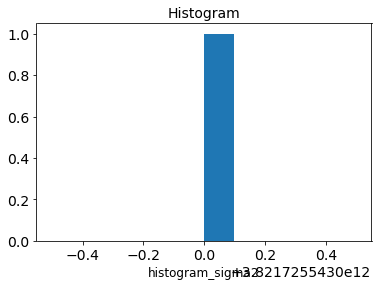

In [18]:
ds = dd['CESM2-FV2.gr.historical.Omon']
h2 = histogram(ds['sigma2'].isel(lev = 0)[10:60], bins = [binz], weights = -1*ds.fgco2[10:60]*A[10:60]*conversion) 
# h2.plot(label = name)
h2.sel(sigma2_bin = 35.64, method = 'nearest').plot()

In [29]:
PCO2_sigma['CESM2-FV2.gr.historical.Omon'].sel(sigma2 = 35.64, method = 'nearest').sel(y = -50.5, method = 'nearest')
# PCO2_sigma['CESM2-FV2.gr.historical.Omon'].sigma2

<xarray.DataArray 'dissic' ()>
array(313.72003404)
Coordinates:
    y        float64 -50.5
    sigma2   float64 35.62

# CESM2-WACCM-FV2
sigma_max = 35.64

fgco2_max = 4.4050589e+12

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([4.4050589e+12, 4.4050589e+12, 4.4050589e+12, 4.4050589e+12,
        4.4050589e+12, 4.4050589e+12, 4.4050589e+12, 4.4050589e+12,
        4.4050589e+12, 4.4050589e+12, 4.4050589e+12]),
 <BarContainer object of 10 artists>)

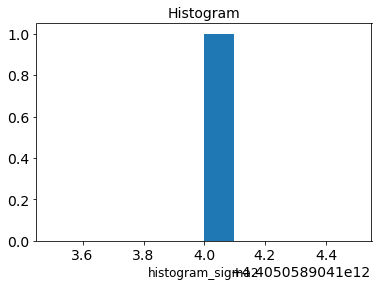

In [19]:
ds = dd['CESM2-WACCM-FV2.gr.historical.Omon']
h2 = histogram(ds['sigma2'].isel(lev = 0)[10:60], bins = [binz], weights = -1*ds.fgco2[10:60]*A[10:60]*conversion) 
# h2.plot(label = name)
# plt.xticks([35.071429, 35.214286, 35.357143, 35.5     , 35.642857, 35.785714,
#        35.928571, 36.071429, 36.214286, 36.357143, 36.5     , 36.642857,
#        36.785714, 36.928571])
h2.sel(sigma2_bin = 35.64, method = 'nearest').plot()

In [30]:
PCO2_sigma['CESM2-WACCM-FV2.gr.historical.Omon'].sel(sigma2 = 35.64, method = 'nearest').sel(y = -50.5, method = 'nearest')


<xarray.DataArray 'dissic' ()>
array(320.76728891)
Coordinates:
    y        float64 -50.5
    sigma2   float64 35.62

# CESM2-WACCM
sigma_max = 35.786

fgco2_max = 4.47906349e+12

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([4.47906349e+12, 4.47906349e+12, 4.47906349e+12, 4.47906349e+12,
        4.47906349e+12, 4.47906349e+12, 4.47906349e+12, 4.47906349e+12,
        4.47906349e+12, 4.47906349e+12, 4.47906349e+12]),
 <BarContainer object of 10 artists>)

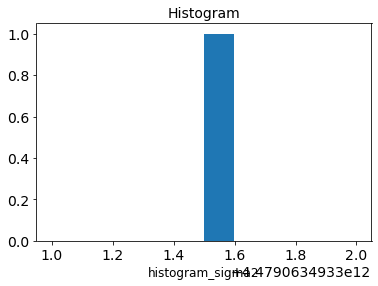

In [20]:
ds = dd['CESM2-WACCM.gr.historical.Omon']
h2 = histogram(ds['sigma2'].isel(lev = 0)[10:60], bins = [binz], weights = -1*ds.fgco2[10:60]*A[10:60]*conversion) 
# h2.plot(label = name)
# plt.xticks([35.071429, 35.214286, 35.357143, 35.5     , 35.642857, 35.785714,
#        35.928571, 36.071429, 36.214286, 36.357143, 36.5     , 36.642857,
#        36.785714, 36.928571])
h2.sel(sigma2_bin = 35.786, method = 'nearest').plot()

In [31]:
PCO2_sigma['CESM2-WACCM.gr.historical.Omon'].sel(sigma2 = 35.786, method = 'nearest').sel(y = -50.5, method = 'nearest')


<xarray.DataArray 'dissic' ()>
array(313.9571573)
Coordinates:
    y        float64 -50.5
    sigma2   float64 35.76

# CESM2
sigma_max = 35.786

fgco2_max = 4.45382831e+12

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([4.45382831e+12, 4.45382831e+12, 4.45382831e+12, 4.45382831e+12,
        4.45382831e+12, 4.45382831e+12, 4.45382831e+12, 4.45382831e+12,
        4.45382831e+12, 4.45382831e+12, 4.45382831e+12]),
 <BarContainer object of 10 artists>)

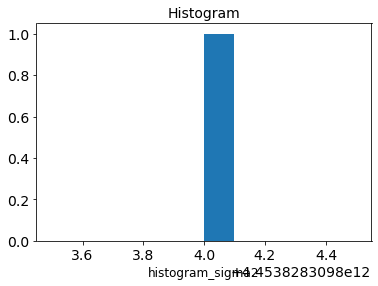

In [21]:
ds = dd['CESM2.gr.historical.Omon']
h2 = histogram(ds['sigma2'].isel(lev = 0)[10:60], bins = [binz], weights = -1*ds.fgco2[10:60]*A[10:60]*conversion) 
# h2.plot(label = name)
# plt.xticks([35.071429, 35.214286, 35.357143, 35.5     , 35.642857, 35.785714,
#        35.928571, 36.071429, 36.214286, 36.357143, 36.5     , 36.642857,
#        36.785714, 36.928571])
h2.sel(sigma2_bin = 35.786, method = 'nearest').plot()

In [32]:
PCO2_sigma['CESM2.gr.historical.Omon'].sel(sigma2 = 35.786, method = 'nearest').sel(y = -50.5, method = 'nearest')
# PCO2_sigma['CESM2.gr.historical.Omon'].sigma2

<xarray.DataArray 'dissic' ()>
array(321.40411158)
Coordinates:
    y        float64 -50.5
    sigma2   float64 35.76

# CNRM-ESM2-1
sigma_max = 36.5

fgco2_max = 1.31941046e+13

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([1.31941046e+13, 1.31941046e+13, 1.31941046e+13, 1.31941046e+13,
        1.31941046e+13, 1.31941046e+13, 1.31941046e+13, 1.31941046e+13,
        1.31941046e+13, 1.31941046e+13, 1.31941046e+13]),
 <BarContainer object of 10 artists>)

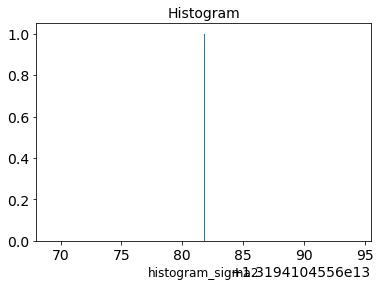

In [22]:
ds = dd['CNRM-ESM2-1.gn.historical.Omon']
h2 = histogram(ds['sigma2'].isel(lev = 0)[10:60], bins = [binz], weights = -1*ds.fgco2[10:60]*A[10:60]*conversion) 
# h2.plot(label = name)
# plt.xticks([35.071429, 35.214286, 35.357143, 35.5     , 35.642857, 35.785714,
#        35.928571, 36.071429, 36.214286, 36.357143, 36.5     , 36.642857,
#        36.785714, 36.928571])
h2.sel(sigma2_bin = 36.5, method = 'nearest').plot()

In [33]:
PCO2_sigma['CNRM-ESM2-1.gn.historical.Omon'].sel(sigma2 = 36.5, method = 'nearest').sel(y = -50.5, method = 'nearest')

<xarray.DataArray 'dissic' ()>
array(604.66798467)
Coordinates:
    y        float64 -50.5
    sigma2   float64 36.52

# CanESM5-CanOE
sigma_max = 36.5

fgco2_max = 4.00576353e+12

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([4.00576353e+12, 4.00576353e+12, 4.00576353e+12, 4.00576353e+12,
        4.00576353e+12, 4.00576353e+12, 4.00576353e+12, 4.00576353e+12,
        4.00576353e+12, 4.00576353e+12, 4.00576353e+12]),
 <BarContainer object of 10 artists>)

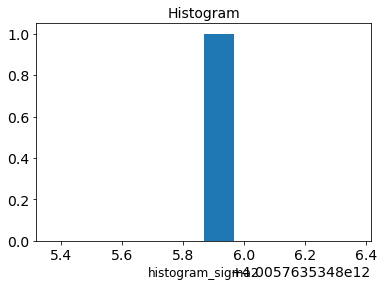

In [23]:
ds = dd['CanESM5-CanOE.gn.historical.Omon']
h2 = histogram(ds['sigma2'].isel(lev = 0)[10:60], bins = [binz], weights = -1*ds.fgco2[10:60]*A[10:60]*conversion) 
# h2.plot(label = name)
# plt.xticks([35.071429, 35.214286, 35.357143, 35.5     , 35.642857, 35.785714,
#        35.928571, 36.071429, 36.214286, 36.357143, 36.5     , 36.642857,
#        36.785714, 36.928571])
h2.sel(sigma2_bin = 36.5, method = 'nearest').plot()

In [34]:
PCO2_sigma['CanESM5-CanOE.gn.historical.Omon'].sel(sigma2 = 36.5, method = 'nearest').sel(y = -50.5, method = 'nearest')

<xarray.DataArray 'dissic' ()>
array(419.89483312)
Coordinates:
    y        float64 -50.5
    sigma2   float64 36.52

# CanESM5
sigma_max = 35.786

fgco2_max = 4.62867767e+12

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([4.62867767e+12, 4.62867767e+12, 4.62867767e+12, 4.62867767e+12,
        4.62867767e+12, 4.62867767e+12, 4.62867767e+12, 4.62867767e+12,
        4.62867767e+12, 4.62867767e+12, 4.62867767e+12]),
 <BarContainer object of 10 artists>)

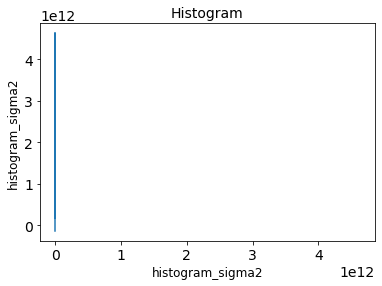

In [26]:
ds = dd['CanESM5.gn.historical.Omon']
h2 = histogram(ds['sigma2'].isel(lev = 0)[10:60], bins = [binz], weights = -1*ds.fgco2[10:60]*A[10:60]*conversion) 
h2.plot(label = name)
# plt.xticks([35.071429, 35.214286, 35.357143, 35.5     , 35.642857, 35.785714,
#        35.928571, 36.071429, 36.214286, 36.357143, 36.5     , 36.642857,
#        36.785714, 36.928571])
h2.sel(sigma2_bin = 35.786, method = 'nearest').plot()

In [35]:
PCO2_sigma['CanESM5.gn.historical.Omon'].sel(sigma2 = 35.786, method = 'nearest').sel(y = -50.5, method = 'nearest')

<xarray.DataArray 'dissic' ()>
array(349.53620485)
Coordinates:
    y        float64 -50.5
    sigma2   float64 35.76

# GFDL-CM4
sigma_max = 35.929

fgco2_max = 4.99335948e+12

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([4.99335948e+12, 4.99335948e+12, 4.99335948e+12, 4.99335948e+12,
        4.99335948e+12, 4.99335948e+12, 4.99335948e+12, 4.99335948e+12,
        4.99335948e+12, 4.99335948e+12, 4.99335948e+12]),
 <BarContainer object of 10 artists>)

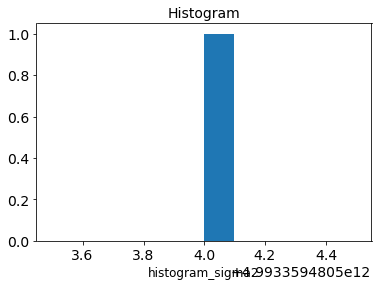

In [27]:
ds = dd['GFDL-CM4.gr.historical.Omon']
h2 = histogram(ds['sigma2'].isel(lev = 0)[10:60], bins = [binz], weights = -1*ds.fgco2[10:60]*A[10:60]*conversion) 
# h2.plot(label = name)
# plt.xticks([35.071429, 35.214286, 35.357143, 35.5     , 35.642857, 35.785714,
#        35.928571, 36.071429, 36.214286, 36.357143, 36.5     , 36.642857,
#        36.785714, 36.928571])
h2.sel(sigma2_bin = 35.929, method = 'nearest').plot()

In [36]:
PCO2_sigma['GFDL-CM4.gr.historical.Omon'].sel(sigma2 = 35.929, method = 'nearest').sel(y = -50.5, method = 'nearest')

<xarray.DataArray 'dissic' ()>
array(295.32326683)
Coordinates:
    y        float64 -50.5
    sigma2   float64 35.9

# GFDL-ESM4
sigma_max = 36.643

fgco2_max = 2.8432428e+12

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([2.8432428e+12, 2.8432428e+12, 2.8432428e+12, 2.8432428e+12,
        2.8432428e+12, 2.8432428e+12, 2.8432428e+12, 2.8432428e+12,
        2.8432428e+12, 2.8432428e+12, 2.8432428e+12]),
 <BarContainer object of 10 artists>)

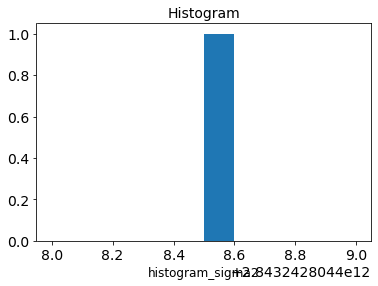

In [28]:
ds = dd['GFDL-ESM4.gr.historical.Omon']
h2 = histogram(ds['sigma2'].isel(lev = 0)[10:60], bins = [binz], weights = -1*ds.fgco2[10:60]*A[10:60]*conversion) 
# h2.plot(label = name)
# plt.xticks([35.071429, 35.214286, 35.357143, 35.5     , 35.642857, 35.785714,
#        35.928571, 36.071429, 36.214286, 36.357143, 36.5     , 36.642857,
#        36.785714, 36.928571])
h2.sel(sigma2_bin = 36.643, method = 'nearest').plot()

In [37]:
PCO2_sigma['GFDL-ESM4.gr.historical.Omon'].sel(sigma2 = 36.643, method = 'nearest').sel(y = -50.5, method = 'nearest')

<xarray.DataArray 'dissic' ()>
array(477.00099417)
Coordinates:
    y        float64 -50.5
    sigma2   float64 36.66

# IPSL-CM6A-LR
sigma_max= 36.357

fgco2_max = 4.89127134e+12

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([4.89127134e+12, 4.89127134e+12, 4.89127134e+12, 4.89127134e+12,
        4.89127134e+12, 4.89127134e+12, 4.89127134e+12, 4.89127134e+12,
        4.89127134e+12, 4.89127134e+12, 4.89127134e+12]),
 <BarContainer object of 10 artists>)

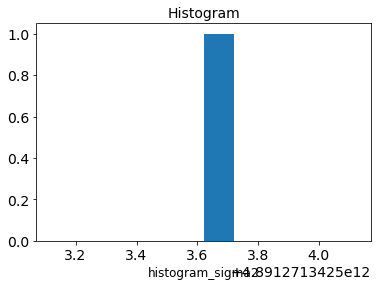

In [29]:
ds = dd['IPSL-CM6A-LR.gn.historical.Omon']
h2 = histogram(ds['sigma2'].isel(lev = 0)[10:60], bins = [binz], weights = -1*ds.fgco2[10:60]*A[10:60]*conversion) 
# h2.plot(label = name)
# plt.xticks([35.071429, 35.214286, 35.357143, 35.5     , 35.642857, 35.785714,
#        35.928571, 36.071429, 36.214286, 36.357143, 36.5     , 36.642857,
#        36.785714, 36.928571])
h2.sel(sigma2_bin = 36.357, method = 'nearest').plot()

In [38]:
PCO2_sigma['IPSL-CM6A-LR.gn.historical.Omon'].sel(sigma2 = 36.357, method = 'nearest').sel(y = -50.5, method = 'nearest')

<xarray.DataArray 'dissic' ()>
array(475.01578832)
Coordinates:
    y        float64 -50.5
    sigma2   float64 36.38

# MRI-ESM2-0
sigma_max = 36.071

fgco2_max = 7.8183982e+12

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([7.8183982e+12, 7.8183982e+12, 7.8183982e+12, 7.8183982e+12,
        7.8183982e+12, 7.8183982e+12, 7.8183982e+12, 7.8183982e+12,
        7.8183982e+12, 7.8183982e+12, 7.8183982e+12]),
 <BarContainer object of 10 artists>)

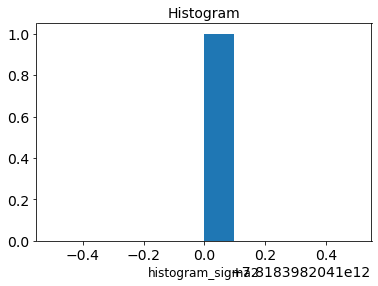

In [30]:
ds = dd['MRI-ESM2-0.gr.historical.Omon']
h2 = histogram(ds['sigma2'].isel(lev = 0)[10:60], bins = [binz], weights = -1*ds.fgco2[10:60]*A[10:60]*conversion) 
# h2.plot(label = name)
# plt.xticks([35.071429, 35.214286, 35.357143, 35.5     , 35.642857, 35.785714,
#        35.928571, 36.071429, 36.214286, 36.357143, 36.5     , 36.642857,
#        36.785714, 36.928571])
h2.sel(sigma2_bin = 36.071, method = 'nearest').plot()

In [39]:
PCO2_sigma['MRI-ESM2-0.gr.historical.Omon'].sel(sigma2 = 36.071, method = 'nearest').sel(y = -50.5, method = 'nearest')

<xarray.DataArray 'dissic' ()>
array(332.62149919)
Coordinates:
    y        float64 -50.5
    sigma2   float64 36.1

# UKESM1-0-LL
sigma_max = 35.643

fgco2_max = 1.7346712e+12

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([1.7346712e+12, 1.7346712e+12, 1.7346712e+12, 1.7346712e+12,
        1.7346712e+12, 1.7346712e+12, 1.7346712e+12, 1.7346712e+12,
        1.7346712e+12, 1.7346712e+12, 1.7346712e+12]),
 <BarContainer object of 10 artists>)

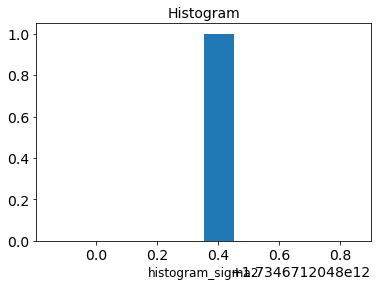

In [31]:
ds = dd['UKESM1-0-LL.gn.historical.Omon']
h2 = histogram(ds['sigma2'].isel(lev = 0)[10:60], bins = [binz], weights = -1*ds.fgco2[10:60]*A[10:60]*conversion) 
# h2.plot(label = name)
# plt.xticks([35.071429, 35.214286, 35.357143, 35.5     , 35.642857, 35.785714,
#        35.928571, 36.071429, 36.214286, 36.357143, 36.5     , 36.642857,
#        36.785714, 36.928571])
h2.sel(sigma2_bin = 35.643, method = 'nearest').plot()

In [40]:
PCO2_sigma['UKESM1-0-LL.gn.historical.Omon'].sel(sigma2 = 35.643, method = 'nearest').sel(y = -50.5, method = 'nearest')

<xarray.DataArray 'dissic' ()>
array(328.09412694)
Coordinates:
    y        float64 -50.5
    sigma2   float64 35.62

0.3523436125962323


Text(0, 0.5, 'max fgco2 regardless of sigma surf')

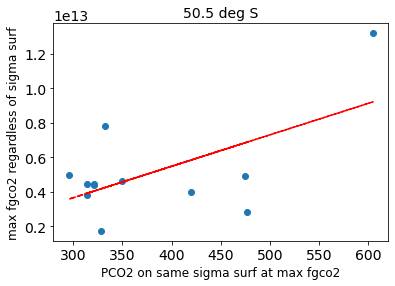

In [13]:
# With CNRM
ppco2_50_5 = [313.72003404, 320.76728891, 313.9571573, 321.40411158, 604.66798467, 419.89483312, 
 349.53620485, 295.32326683, 477.00099417, 475.01578832, 332.62149919, 328.09412694]
fgco2_max = [3.82172554e+12, 4.4050589e+12, 4.47906349e+12, 4.45382831e+12, 1.31941046e+13, 
             4.00576353e+12, 4.62867767e+12, 4.99335948e+12, 2.8432428e+12, 4.89127134e+12, 
             7.8183982e+12, 1.7346712e+12]

# ppco2_50_5 = [313.72003404, 320.76728891, 313.9571573, 321.40411158, 419.89483312, 
#  349.53620485, 295.32326683, 477.00099417, 475.01578832, 332.62149919, 328.09412694]
# fgco2_max = [3.82172554e+12, 4.4050589e+12, 4.47906349e+12, 4.45382831e+12, 
#              4.00576353e+12, 4.62867767e+12, 4.99335948e+12, 2.8432428e+12, 4.89127134e+12, 
#              7.8183982e+12, 1.7346712e+12]
plt.scatter(ppco2_50_5, fgco2_max)
# calc the trendline
z = np.polyfit(ppco2_50_5, fgco2_max, 1)
pp = np.poly1d(z)
plt.plot(ppco2_50_5,pp(ppco2_50_5),"r--")
correlation_matrix = np.corrcoef(ppco2_50_5, fgco2_max)
correlation_xy = correlation_matrix[0,1]
r_sq = correlation_xy**2
print(r_sq)
# the line equation:
# print("y=%.6fx+(%.6f)"%(z[0],z[1]))
# print('slope: ' +  str(z[0]) )
# print('int: ' + str(z[1]))
plt.title('50.5 deg S')
plt.xlabel('PCO2 on same sigma surf at max fgco2')
plt.ylabel('max fgco2 regardless of sigma surf')

In [14]:
ppco2_375 = [PCO2_sigma['CESM2-FV2.gr.historical.Omon'].sel(sigma2 = 35.64, method = 'nearest').sel(y = -37.5, method = 'nearest'),
            PCO2_sigma['CESM2-WACCM-FV2.gr.historical.Omon'].sel(sigma2 = 35.64, method = 'nearest').sel(y = -37.5, method = 'nearest'),
            PCO2_sigma['CESM2-WACCM.gr.historical.Omon'].sel(sigma2 = 35.786, method = 'nearest').sel(y = -37.5, method = 'nearest'),
            PCO2_sigma['CESM2.gr.historical.Omon'].sel(sigma2 = 35.786, method = 'nearest').sel(y = -37.5, method = 'nearest'),
            PCO2_sigma['CNRM-ESM2-1.gn.historical.Omon'].sel(sigma2 = 36.5, method = 'nearest').sel(y = -37.5, method = 'nearest'),
            PCO2_sigma['CanESM5-CanOE.gn.historical.Omon'].sel(sigma2 = 36.5, method = 'nearest').sel(y = -37.5, method = 'nearest'),
            PCO2_sigma['CanESM5.gn.historical.Omon'].sel(sigma2 = 35.786, method = 'nearest').sel(y = -37.5, method = 'nearest'),
            PCO2_sigma['GFDL-CM4.gr.historical.Omon'].sel(sigma2 = 35.929, method = 'nearest').sel(y = -37.5, method = 'nearest'),
            PCO2_sigma['GFDL-ESM4.gr.historical.Omon'].sel(sigma2 = 36.643, method = 'nearest').sel(y = -37.5, method = 'nearest'),
            PCO2_sigma['IPSL-CM6A-LR.gn.historical.Omon'].sel(sigma2 = 36.357, method = 'nearest').sel(y = -37.5, method = 'nearest'),
            PCO2_sigma['MRI-ESM2-0.gr.historical.Omon'].sel(sigma2 = 36.071, method = 'nearest').sel(y = -37.5, method = 'nearest'),
           PCO2_sigma['UKESM1-0-LL.gn.historical.Omon'].sel(sigma2 = 35.643, method = 'nearest').sel(y = -37.5, method = 'nearest')]
plt.scatter(ppco2_375, fgco2_max)
# calc the trendline
z = np.polyfit(ppco2_375, fgco2_max, 1)
pp = np.poly1d(z)
plt.plot(ppco2_375,pp(ppco2_375),"r--")
correlation_matrix = np.corrcoef(ppco2_375, fgco2_max)
correlation_xy = correlation_matrix[0,1]
r_sq = correlation_xy**2
print(r_sq)
# the line equation:
# print("y=%.6fx+(%.6f)"%(z[0],z[1]))
# print('slope: ' +  str(z[0]) )
# print('int: ' + str(z[1]))
plt.title('37.5 deg S')
plt.xlabel('PCO2 on same sigma surf at max fgco2')
plt.ylabel('max fgco2 regardless of sigma surf')

NameError: name 'PCO2_sigma' is not defined

0.33123862750059135


Text(0, 0.5, 'max fgco2 regardless of sigma surf')

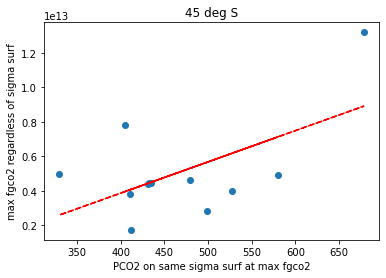

In [37]:
ppco2_45 = [PCO2_sigma['CESM2-FV2.gr.historical.Omon'].sel(sigma2 = 35.64, method = 'nearest').sel(y = -45, method = 'nearest'),
            PCO2_sigma['CESM2-WACCM-FV2.gr.historical.Omon'].sel(sigma2 = 35.64, method = 'nearest').sel(y = -45, method = 'nearest'),
            PCO2_sigma['CESM2-WACCM.gr.historical.Omon'].sel(sigma2 = 35.786, method = 'nearest').sel(y = -45, method = 'nearest'),
            PCO2_sigma['CESM2.gr.historical.Omon'].sel(sigma2 = 35.786, method = 'nearest').sel(y = -45, method = 'nearest'),
            PCO2_sigma['CNRM-ESM2-1.gn.historical.Omon'].sel(sigma2 = 36.5, method = 'nearest').sel(y = -45, method = 'nearest'),
            PCO2_sigma['CanESM5-CanOE.gn.historical.Omon'].sel(sigma2 = 36.5, method = 'nearest').sel(y = -45, method = 'nearest'),
            PCO2_sigma['CanESM5.gn.historical.Omon'].sel(sigma2 = 35.786, method = 'nearest').sel(y = -45, method = 'nearest'),
            PCO2_sigma['GFDL-CM4.gr.historical.Omon'].sel(sigma2 = 35.929, method = 'nearest').sel(y = -45, method = 'nearest'),
            PCO2_sigma['GFDL-ESM4.gr.historical.Omon'].sel(sigma2 = 36.643, method = 'nearest').sel(y = -45, method = 'nearest'),
            PCO2_sigma['IPSL-CM6A-LR.gn.historical.Omon'].sel(sigma2 = 36.357, method = 'nearest').sel(y = -45, method = 'nearest'),
            PCO2_sigma['MRI-ESM2-0.gr.historical.Omon'].sel(sigma2 = 36.071, method = 'nearest').sel(y = -45, method = 'nearest'),
           PCO2_sigma['UKESM1-0-LL.gn.historical.Omon'].sel(sigma2 = 35.643, method = 'nearest').sel(y = -45, method = 'nearest')]
plt.scatter(ppco2_45, fgco2_max)
# calc the trendline
z = np.polyfit(ppco2_45, fgco2_max, 1)
pp = np.poly1d(z)
plt.plot(ppco2_45,pp(ppco2_45),"r--")
correlation_matrix = np.corrcoef(ppco2_45, fgco2_max)
correlation_xy = correlation_matrix[0,1]
r_sq = correlation_xy**2
print(r_sq)
# the line equation:
# print("y=%.6fx+(%.6f)"%(z[0],z[1]))
# print('slope: ' +  str(z[0]) )
# print('int: ' + str(z[1]))
plt.title('45 deg S')
plt.xlabel('PCO2 on same sigma surf at max fgco2')
plt.ylabel('max fgco2 regardless of sigma surf')

0.5093002235821066


Text(0, 0.5, 'max fgco2 regardless of sigma surf')

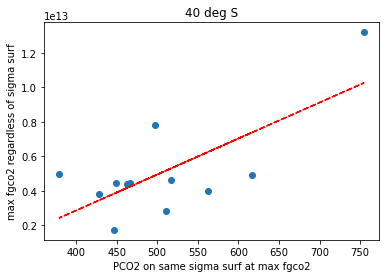

In [38]:
ppco2_40 = [PCO2_sigma['CESM2-FV2.gr.historical.Omon'].sel(sigma2 = 35.64, method = 'nearest').sel(y = -40, method = 'nearest'),
            PCO2_sigma['CESM2-WACCM-FV2.gr.historical.Omon'].sel(sigma2 = 35.64, method = 'nearest').sel(y = -40, method = 'nearest'),
            PCO2_sigma['CESM2-WACCM.gr.historical.Omon'].sel(sigma2 = 35.786, method = 'nearest').sel(y = -40, method = 'nearest'),
            PCO2_sigma['CESM2.gr.historical.Omon'].sel(sigma2 = 35.786, method = 'nearest').sel(y = -40, method = 'nearest'),
            PCO2_sigma['CNRM-ESM2-1.gn.historical.Omon'].sel(sigma2 = 36.5, method = 'nearest').sel(y = -40, method = 'nearest'),
            PCO2_sigma['CanESM5-CanOE.gn.historical.Omon'].sel(sigma2 = 36.5, method = 'nearest').sel(y = -40, method = 'nearest'),
            PCO2_sigma['CanESM5.gn.historical.Omon'].sel(sigma2 = 35.786, method = 'nearest').sel(y = -40, method = 'nearest'),
            PCO2_sigma['GFDL-CM4.gr.historical.Omon'].sel(sigma2 = 35.929, method = 'nearest').sel(y = -40, method = 'nearest'),
            PCO2_sigma['GFDL-ESM4.gr.historical.Omon'].sel(sigma2 = 36.643, method = 'nearest').sel(y = -40, method = 'nearest'),
            PCO2_sigma['IPSL-CM6A-LR.gn.historical.Omon'].sel(sigma2 = 36.357, method = 'nearest').sel(y = -40, method = 'nearest'),
            PCO2_sigma['MRI-ESM2-0.gr.historical.Omon'].sel(sigma2 = 36.071, method = 'nearest').sel(y = -40, method = 'nearest'),
           PCO2_sigma['UKESM1-0-LL.gn.historical.Omon'].sel(sigma2 = 35.643, method = 'nearest').sel(y = -40, method = 'nearest')]
plt.scatter(ppco2_40, fgco2_max)

# calc the trendline
z = np.polyfit(ppco2_40, fgco2_max, 1)
pp = np.poly1d(z)
plt.plot(ppco2_40,pp(ppco2_40),"r--")
correlation_matrix = np.corrcoef(ppco2_40, fgco2_max)
correlation_xy = correlation_matrix[0,1]
r_sq = correlation_xy**2
print(r_sq)
# the line equation:
# print("y=%.6fx+(%.6f)"%(z[0],z[1]))
# print('slope: ' +  str(z[0]) )
# print('int: ' + str(z[1]))
plt.title('40 deg S')
plt.xlabel('PCO2 on same sigma surf at max fgco2')
plt.ylabel('max fgco2 regardless of sigma surf')

0.5403295904053925


Text(0, 0.5, 'max fgco2 regardless of sigma surf')

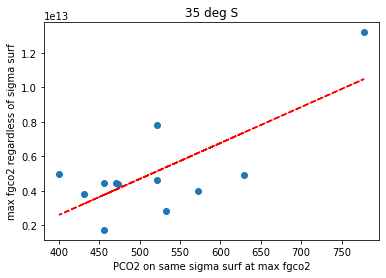

In [39]:
ppco2_35 = [PCO2_sigma['CESM2-FV2.gr.historical.Omon'].sel(sigma2 = 35.64, method = 'nearest').sel(y = -35, method = 'nearest'),
            PCO2_sigma['CESM2-WACCM-FV2.gr.historical.Omon'].sel(sigma2 = 35.64, method = 'nearest').sel(y = -35, method = 'nearest'),
            PCO2_sigma['CESM2-WACCM.gr.historical.Omon'].sel(sigma2 = 35.786, method = 'nearest').sel(y = -35, method = 'nearest'),
            PCO2_sigma['CESM2.gr.historical.Omon'].sel(sigma2 = 35.786, method = 'nearest').sel(y = -35, method = 'nearest'),
            PCO2_sigma['CNRM-ESM2-1.gn.historical.Omon'].sel(sigma2 = 36.5, method = 'nearest').sel(y = -35, method = 'nearest'),
            PCO2_sigma['CanESM5-CanOE.gn.historical.Omon'].sel(sigma2 = 36.5, method = 'nearest').sel(y = -35, method = 'nearest'),
            PCO2_sigma['CanESM5.gn.historical.Omon'].sel(sigma2 = 35.786, method = 'nearest').sel(y = -35, method = 'nearest'),
            PCO2_sigma['GFDL-CM4.gr.historical.Omon'].sel(sigma2 = 35.929, method = 'nearest').sel(y = -35, method = 'nearest'),
            PCO2_sigma['GFDL-ESM4.gr.historical.Omon'].sel(sigma2 = 36.643, method = 'nearest').sel(y = -35, method = 'nearest'),
            PCO2_sigma['IPSL-CM6A-LR.gn.historical.Omon'].sel(sigma2 = 36.357, method = 'nearest').sel(y = -35, method = 'nearest'),
            PCO2_sigma['MRI-ESM2-0.gr.historical.Omon'].sel(sigma2 = 36.071, method = 'nearest').sel(y = -35, method = 'nearest'),
           PCO2_sigma['UKESM1-0-LL.gn.historical.Omon'].sel(sigma2 = 35.643, method = 'nearest').sel(y = -35, method = 'nearest')]
plt.scatter(ppco2_35, fgco2_max)





# calc the trendline
z = np.polyfit(ppco2_35, fgco2_max, 1)
pp = np.poly1d(z)
plt.plot(ppco2_35,pp(ppco2_35),"r--")
correlation_matrix = np.corrcoef(ppco2_35, fgco2_max)
correlation_xy = correlation_matrix[0,1]
r_sq = correlation_xy**2
print(r_sq)
# the line equation:
# print("y=%.6fx+(%.6f)"%(z[0],z[1]))
# print('slope: ' +  str(z[0]) )
# print('int: ' + str(z[1]))
plt.title('35 deg S')
plt.xlabel('PCO2 on same sigma surf at max fgco2')
plt.ylabel('max fgco2 regardless of sigma surf')

0.5457845610574018


Text(0, 0.5, 'max fgco2 regardless of sigma surf')

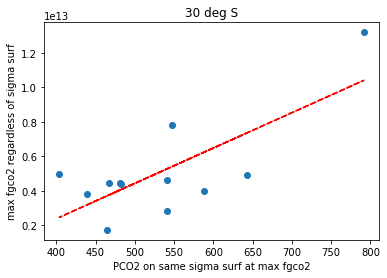

In [40]:
ppco2_30 = [PCO2_sigma['CESM2-FV2.gr.historical.Omon'].sel(sigma2 = 35.64, method = 'nearest').sel(y = -31, method = 'nearest'),
            PCO2_sigma['CESM2-WACCM-FV2.gr.historical.Omon'].sel(sigma2 = 35.64, method = 'nearest').sel(y = -31, method = 'nearest'),
            PCO2_sigma['CESM2-WACCM.gr.historical.Omon'].sel(sigma2 = 35.786, method = 'nearest').sel(y = -31, method = 'nearest'),
            PCO2_sigma['CESM2.gr.historical.Omon'].sel(sigma2 = 35.786, method = 'nearest').sel(y = -31, method = 'nearest'),
            PCO2_sigma['CNRM-ESM2-1.gn.historical.Omon'].sel(sigma2 = 36.5, method = 'nearest').sel(y = -31, method = 'nearest'),
            PCO2_sigma['CanESM5-CanOE.gn.historical.Omon'].sel(sigma2 = 36.5, method = 'nearest').sel(y = -31, method = 'nearest'),
            PCO2_sigma['CanESM5.gn.historical.Omon'].sel(sigma2 = 35.786, method = 'nearest').sel(y = -31, method = 'nearest'),
            PCO2_sigma['GFDL-CM4.gr.historical.Omon'].sel(sigma2 = 35.929, method = 'nearest').sel(y = -31, method = 'nearest'),
            PCO2_sigma['GFDL-ESM4.gr.historical.Omon'].sel(sigma2 = 36.643, method = 'nearest').sel(y = -31, method = 'nearest'),
            PCO2_sigma['IPSL-CM6A-LR.gn.historical.Omon'].sel(sigma2 = 36.357, method = 'nearest').sel(y = -31, method = 'nearest'),
            PCO2_sigma['MRI-ESM2-0.gr.historical.Omon'].sel(sigma2 = 36.071, method = 'nearest').sel(y = -31, method = 'nearest'),
           PCO2_sigma['UKESM1-0-LL.gn.historical.Omon'].sel(sigma2 = 35.643, method = 'nearest').sel(y = -31, method = 'nearest')]
plt.scatter(ppco2_30, fgco2_max)



# calc the trendline
z = np.polyfit(ppco2_30, fgco2_max, 1)
pp = np.poly1d(z)
plt.plot(ppco2_30,pp(ppco2_30),"r--")
correlation_matrix = np.corrcoef(ppco2_30, fgco2_max)
correlation_xy = correlation_matrix[0,1]
r_sq = correlation_xy**2
print(r_sq)
# the line equation:
# print("y=%.6fx+(%.6f)"%(z[0],z[1]))
# print('slope: ' +  str(z[0]) )
# print('int: ' + str(z[1]))
plt.title('30 deg S')
plt.xlabel('PCO2 on same sigma surf at max fgco2')
plt.ylabel('max fgco2 regardless of sigma surf')

ppco2_30

<xarray.DataArray 'dissic' ()>
array(nan)
Coordinates:
    y        float64 -29.5
    sigma2   float64 35.62

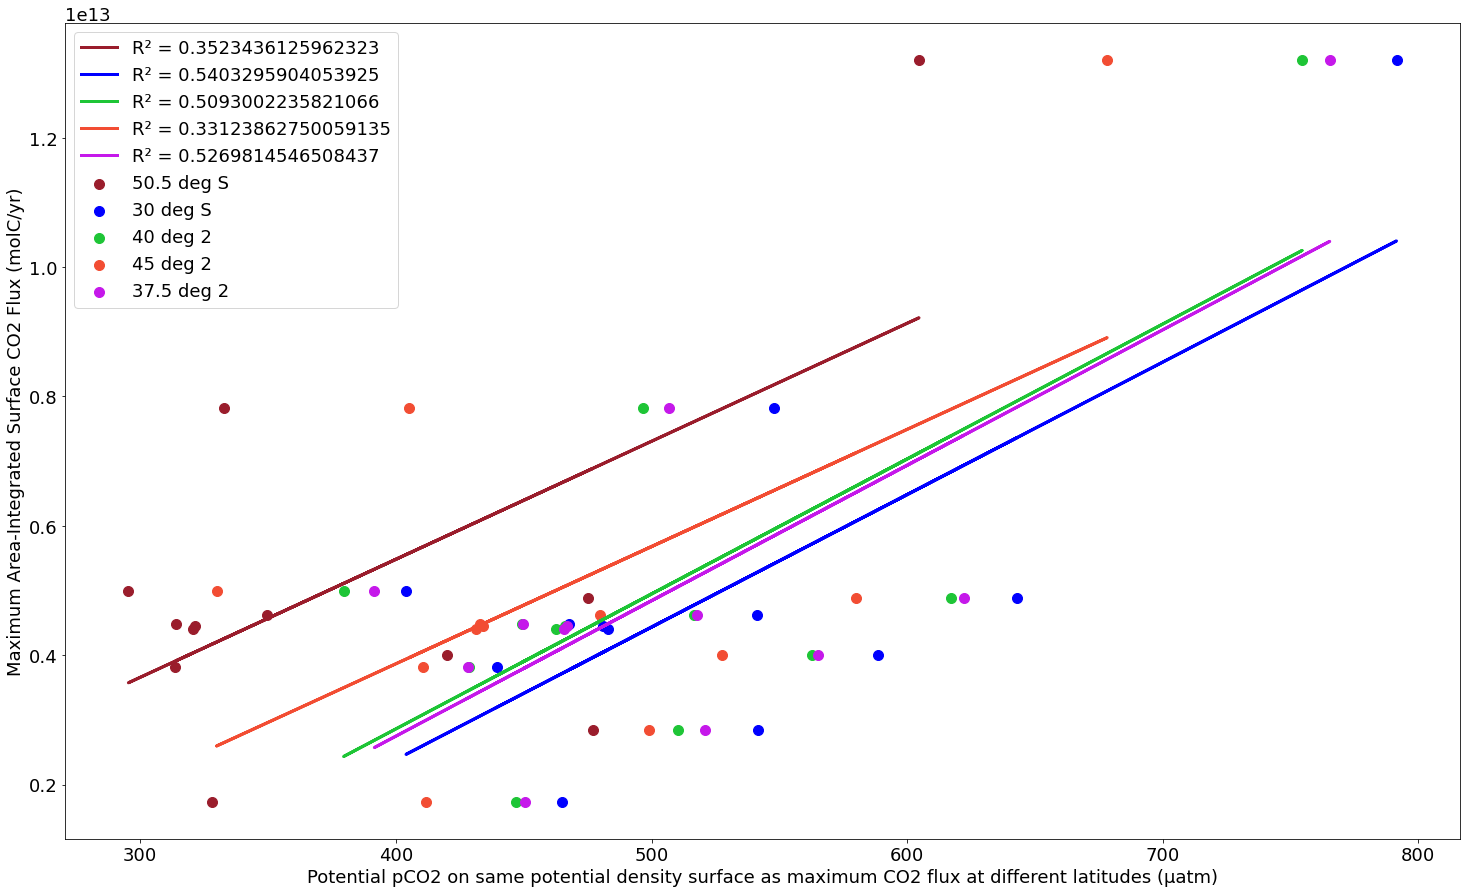

In [86]:
plt.rc('font', size = 18)
plt.rc('axes', titlesize= 18)    
plt.rc('axes', labelsize= 18)
plt.rc('figure', titlesize=18)

plt.scatter(ppco2_50_5, fgco2_max, s = 100, c = '#9a1d2c', label = '50.5 deg S')
z = np.polyfit(ppco2_50_5, fgco2_max, 1)
pp = np.poly1d(z)
plt.plot(ppco2_50_5,pp(ppco2_50_5),c = "#9a1d2c", lw = 3, label = 'R\u00b2 = 0.3523436125962323')

plt.scatter(ppco2_30, fgco2_max, s = 100, c = 'b', label = '30 deg S')
z = np.polyfit(ppco2_30, fgco2_max, 1)
pp = np.poly1d(z)
plt.plot(ppco2_30,pp(ppco2_30),"b", lw = 3, label = 'R\u00b2 = 0.5403295904053925')

plt.scatter(ppco2_40, fgco2_max, s = 100, c = '#1ec536', label = '40 deg 2')
z = np.polyfit(ppco2_40, fgco2_max, 1)
pp = np.poly1d(z)
plt.plot(ppco2_40,pp(ppco2_40),c = '#1ec536', lw = 3, label = 'R\u00b2 = 0.5093002235821066')

plt.scatter(ppco2_45, fgco2_max, s = 100, c = '#f24d33', label = '45 deg 2')
z = np.polyfit(ppco2_45, fgco2_max, 1)
pp = np.poly1d(z)
plt.plot(ppco2_45,pp(ppco2_45),c = '#f24d33', lw = 3, label = 'R\u00b2 = 0.33123862750059135')

plt.scatter(ppco2_375, fgco2_max, s = 100, c = '#c518ea', label = '37.5 deg 2')
z = np.polyfit(ppco2_375, fgco2_max, 1)
pp = np.poly1d(z)
plt.plot(ppco2_375,pp(ppco2_375),c = '#c518ea', lw = 3, label = 'R\u00b2 = 0.5269814546508437')

plt.legend(
#     bbox_to_anchor=(1.05, 1), 
    loc='upper left'
#     , borderaxespad=0.
)
plt.ylabel('Maximum Area-Integrated Surface CO2 Flux (molC/yr)')
plt.xlabel('Potential pCO2 on same potential density surface as maximum CO2 flux at different latitudes (\u03BCatm)')
plt.rcParams["figure.figsize"] = (25,15)

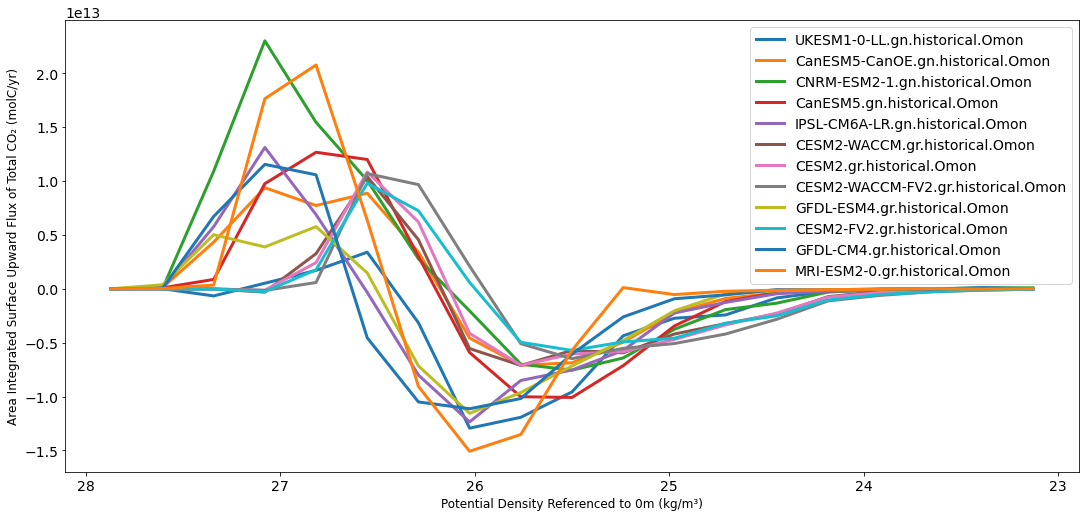

In [16]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=[16,8])
fig.tight_layout(pad = 3.5)
plt.rc('font', size = 14)
plt.rc('axes', titlesize= 14)    
plt.rc('axes', labelsize= 12)
plt.rc('figure', titlesize=16)

target = np.linspace(23, 28, 20)
binz = np.linspace(23, 28, 20)

conversion = 3.1536e7 * 83.3
ax_idx = 0
# for name, ds in dd.items():
for name, ds in dd.items():
#     ax = axarr.flat[ax_idx]
#     if name != 'GFDL-ESM4.gr.historical.Omon':
#         if name != 'GFDL-CM4.gr.historical.Omon':
    h2 = histogram(ds['sigma0'].isel(lev = 0)[10:60], bins = [binz], weights = -1*ds.fgco2[10:60]*A[10:60]*conversion) 
    h2.plot(label = name, lw = 3)
ax.invert_xaxis()
#     ax.set_title(name)
#     ax_idx += 1
ax.set_xlabel('Potential Density Referenced to 0m (kg/m\u00b3)')
ax.set_ylabel('Area Integrated Surface Upward Flux of Total CO\u2082 (molC/yr)')
plt.legend(
#     bbox_to_anchor=(1.05, 1), 
    loc='upper right'
#     , borderaxespad=0.
)

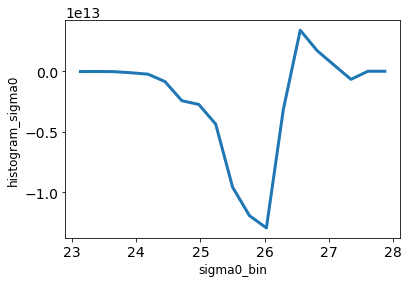

In [34]:
ds = dd['UKESM1-0-LL.gn.historical.Omon']
h2 = histogram(ds['sigma0'].isel(lev = 0)[10:60], bins = [binz], weights = -1*ds.fgco2[10:60]*A[10:60]*conversion) 
h2.plot(label = name, lw = 3)



In [24]:
h2.sigma0_bin

<xarray.DataArray 'sigma0_bin' (sigma0_bin: 19)>
array([23.131579, 23.394737, 23.657895, 23.921053, 24.184211, 24.447368,
       24.710526, 24.973684, 25.236842, 25.5     , 25.763158, 26.026316,
       26.289474, 26.552632, 26.815789, 27.078947, 27.342105, 27.605263,
       27.868421])
Coordinates:
  * sigma0_bin  (sigma0_bin) float64 23.13 23.39 23.66 ... 27.34 27.61 27.87
Attributes: (12/18)
    cell_measures:  area: areacello volume: volcello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    description:    Sea water salinity is the salt content of sea water, ofte...
    frequency:      mon
    id:             so
    ...             ...
    time:           time
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Sea Water Salinity
    type:           real
    variable_id:    so